# Making Top Song Prediction

***

## Importing Data with SQLite and cleaning table with Pandas

In [1]:
import sqlite3
import pandas as pd

In [2]:
# Connect to DB
conn = sqlite3.connect("spotify.db") 

# Grab tables
tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", conn)
print(tables)

# Select Table
table_name = tables.iloc[1, 0]  # second table with lowercase column names, 'spotify'

                           name
0                        tracks
1                       spotify
2  spotify_dropped_ids_pictures


In [3]:
# Read into pandas df
df = pd.read_sql_query(f"SELECT * FROM {table_name};", conn) # Takes a sql query and sql connection

# Peek the tables
print("\nFirst Entries:")
# print(df.head())
print(df.head().to_string(index=False)) # remove line wrapping in notebook
print(len(df))


First Entries:
                  track_name         artist_name           album_name track_duration  track_popularity track_release_date  explicit         isrc                  artist_genre  artist_popularity  artist_follower_count                                                    album_picture                                                   artist_picture               album_id               track_id              artist_id  top_songs_rating  top_artist_ranking           date_added
                     Sarcasm          Get Scared    Best Kind Of Mess           3:18                67         2010-01-01         1 USUM71021465 emo, metalcore, post-hardcore                 58                 764241 https://i.scdn.co/image/ab67616d0000b27381c8341abbed9421975ca71d https://i.scdn.co/image/ab6761610000e5eb0aaa9d35794ed0470d2f5072 3xkOfH5nqIMm4b8qDWlzLj 40i81AcCCxiVEFUWElcjZC 5r9uIJCoquVtEkCkvcn8Ez                 1                21.0 2023-05-02T19:26:56Z
                 Glass Heart      

## Data Cleaning

In [4]:
# Data Cleaning

# Drop IDs and Link Features
df.drop(columns=[
    'album_picture',
    'artist_picture',
    'album_id',
    'track_id',
    'artist_id',
    'isrc',
    'date_added' # Half of my dataset is missing this value, will have to ignore temporal context of tracks
], inplace=True)

# Extract Year and Month from Date Features (numerically)

df['track_release_date'] = pd.to_datetime(df['track_release_date'], errors='coerce')
# df['date_added'] = pd.to_datetime(df['date_added'], errors='coerce')

# Overwrite with numeric YYYYMM (int)
df = df[df['track_release_date'].notna()] # Drop NULLS, rare (only 235 entries)

df['track_release_date'] = df['track_release_date'].dt.strftime('%Y%m').astype(int)

###

# top_artist_ranking rename and change type double -> int
df.rename(columns={'top_artist_ranking': 'artist_ranking'}, inplace=True)
df['artist_ranking'] = df['artist_ranking'].fillna(0).astype(int)
df['artist_ranking'] = df['artist_ranking'].astype(int)

# Rename explicit to track_explicit
df.rename(columns={'explicit': 'track_explicit'}, inplace=True)


# Convert 'track_duration' from MM:SS to total seconds (int)
df['track_duration'] = df['track_duration'].str.split(':').apply(
    lambda x: int(x[0]) * 60 + int(x[1])
)

print(df.head().to_string(index=False)) # remove line wrapping in notebook
print(len(df))

                  track_name         artist_name           album_name  track_duration  track_popularity  track_release_date  track_explicit                  artist_genre  artist_popularity  artist_follower_count  top_songs_rating  artist_ranking
                     Sarcasm          Get Scared    Best Kind Of Mess             198                67              201001               1 emo, metalcore, post-hardcore                 58                 764241                 1              21
                 Glass Heart             Caskets           Lost Souls             224                68              202108               0      metalcore, post-hardcore                 61                 209521                 2              14
                      weapon Against The Current                fever             197                59              202107               0                      pop punk                 64                 532952                 3              12
One Hundred Slee

## Defining target variable - my_top_songs (Binary Classification)

### Top Song Definition: **Top 10%** of my total saved songs (Quintile) (~600 songs)

Alternative: Do an Ordinal Regression (data is discrete, not continuous for normal Regression) from 1-6000 on new data (less explainable? (e.g. This song would be your 4628th liked song))

What's nice is that ranking get's preserved, which is pretty valuable data.

It questions how is top songs generated from spotify.
- Play Frequency
- Skips vs. Full Plays
- Long term vs short term favorites (pulled long term from API)

When someone discovers a new song that is unkown to be their favorite, it will have a low top song score because of only 1 listen (cold start?)

A categorical prediction might have more meaning, can be broken up into multi label classification by quintiles. (can come back to this after binary classification)

In [5]:
# Convert the top_songs_rating feature into a binary feature, where positive when a song is in the top 10% of my songs

cutoff = int(len(df) * 0.10)  # top 10% of songs
df['my_top_songs'] = df['top_songs_rating'] <= cutoff
df['my_top_songs'] = df['my_top_songs'].astype(int)  # Convert boolean to 0/1

df.drop(columns=['top_songs_rating'], inplace=True) # cleanup

print(df.head().to_string(index=False)) # remove line wrapping in notebook

                  track_name         artist_name           album_name  track_duration  track_popularity  track_release_date  track_explicit                  artist_genre  artist_popularity  artist_follower_count  artist_ranking  my_top_songs
                     Sarcasm          Get Scared    Best Kind Of Mess             198                67              201001               1 emo, metalcore, post-hardcore                 58                 764241              21             1
                 Glass Heart             Caskets           Lost Souls             224                68              202108               0      metalcore, post-hardcore                 61                 209521              14             1
                      weapon Against The Current                fever             197                59              202107               0                      pop punk                 64                 532952              12             1
One Hundred Sleepless Nights    

In [6]:
#df.to_csv("checking_in.csv", index=False)

# Encoding Text Features and CSV Dumping Nick Specific Feature Data

track_name has a high cardinality, values are mostly unique. However, track names can have semantic meaning in relation to the genre. (e.g. weapon -> pop punk) (e.g. All my Life -> doesn't really indicate a Genre)

(This is a research question in itself)


artist_name I believe is valuable, some artists are frequently saved and have a high ranking, (e.g. every Paramore song is high on ranking, every Taylor Swift song is low on ranking)

album_name has a close tie to artist_name already, if an artist's songs are top ranked, does it matter from which album it came from in their discography? (in the general case no, but there are exceptions)

artist_genre is the most important feature, however there are multiple text entries (e.g. metalcore, post-hardcore), I need to encode these but there are a lot of minority classes that would make one-hot encoding inefficient.

In [7]:
# Drop track_name (not doing NLP/Embeddings right now)
df.drop(columns=['track_name'], inplace=True)

In [8]:
# Drop album_name - close relationship to artist_name
df.drop(columns=['album_name'], inplace=True)

In [9]:
artist_freq = df['artist_name'].value_counts() # pandas series, kind of like a dict
print(artist_freq.head())

artist_name
Ludwig van Beethoven     165
Paramore                 104
The Used                  95
Motionless In White       88
Johann Sebastian Bach     85
Name: count, dtype: int64


In [10]:
# Convert Series to DataFrame
artist_freq_df = artist_freq.rename_axis('artist_name').reset_index(name='count')

# Export to CSV
# artist_freq_df.to_csv('nick_artist_freq.csv', index=False)

In [11]:
# While I'm here - I'll dump a artist_ranking CSV

# Ensure artist_name is in the DataFrame and set as index
# Drop the 0's - they don't matter
df_artist_rank = df[['artist_name', 'artist_ranking']].drop_duplicates().query("artist_ranking != 0").set_index('artist_name').sort_values('artist_ranking')

# Export to CSV
df_artist_rank.to_csv('nick_artist_ranking.csv')

In [12]:
# artist_name - Choose an encoding

# Label Encoding - Give each artist a label - This preserves artist identity - What happens on unseen artist?
# Frequency Encoding - Count how many times the artist appears - Showcases personal preference - when i enter new data, how do i check the frequency?

# Both approaches - need to check if the artist is seen before when making a prediction on unseen data

# Answering "How much do I like this artist?" vs. "Do I know this artist?"
# The how much question also captures the knowing question
# Result: Go with Frequency Encoding
# (e.g. artists named "1293j" and "asjas9" can both have 25 songs saved by me, semantics of artist name and identity arent that important to showing that I'd like either)

artist_freq = df['artist_name'].value_counts() # pandas series, kind of like a dict

print(artist_freq.head())

df['artist_freq'] = df['artist_name'].map(artist_freq) # replace name with frequency
df.drop(columns=['artist_name'], inplace=True)

print(df.head().to_string(index=False)) # remove line wrapping in notebook

artist_name
Ludwig van Beethoven     165
Paramore                 104
The Used                  95
Motionless In White       88
Johann Sebastian Bach     85
Name: count, dtype: int64
 track_duration  track_popularity  track_release_date  track_explicit                  artist_genre  artist_popularity  artist_follower_count  artist_ranking  my_top_songs  artist_freq
            198                67              201001               1 emo, metalcore, post-hardcore                 58                 764241              21             1           58
            224                68              202108               0      metalcore, post-hardcore                 61                 209521              14             1           25
            197                59              202107               0                      pop punk                 64                 532952              12             1           42
            221                69              201207               0   emo, 

# Analyzing Genre Data

In [ ]:
pip install openpyxl

In [21]:
from collections import Counter

# Split genre strings into lists, handling NaNs
genre_lists = df['artist_genre'].dropna().str.split(', ')

# Flatten and count all genres
all_genres = [genre for sublist in genre_lists for genre in sublist]

# unique_genres = sorted(set(all_genres))

# Create DataFrame
genre_df = pd.DataFrame({'genres': all_genres})

# Write to CSV - Dump Total Genre List
genre_df.to_csv('genres_flattened.csv', index=False)

# Save to Excel file
genre_df.to_excel('genres_flattened.xlsx', index=False)

genre_counts = Counter(all_genres)

# Number of unique genres
print(f"Unique genres: {len(genre_counts)}")

# Optional: Top 10 most common genres
print(genre_counts.most_common(10))

print(genre_counts)


# Unkown genres will be 0

Unique genres: 252
[('metalcore', 1771), ('post-hardcore', 1157), ('emo', 1011), ('pop punk', 845), ('screamo', 843), ('metal', 837), ('classical', 602), ('classical piano', 487), ('alternative metal', 401), ('rock', 360)]
Counter({'metalcore': 1771, 'post-hardcore': 1157, 'emo': 1011, 'pop punk': 845, 'screamo': 843, 'metal': 837, 'classical': 602, 'classical piano': 487, 'alternative metal': 401, 'rock': 360, 'chamber music': 289, 'deathcore': 262, 'post-grunge': 244, 'rap metal': 241, 'djent': 235, 'nu metal': 204, 'punk': 180, 'rap': 151, 'christian rock': 143, 'edm': 139, 'hard rock': 136, 'progressive metal': 81, 'big room': 79, 'skate punk': 77, 'rap rock': 74, 'opera': 73, 'christian alternative rock': 70, 'heavy metal': 69, 'requiem': 64, 'orchestra': 61, 'singer-songwriter': 58, 'grunge': 56, 'rage rap': 56, 'melodic rap': 48, 'progressive house': 45, 'melodic hardcore': 44, 'hip hop': 39, 'dubstep': 39, 'hardcore punk': 37, 'alternative rock': 35, 'groove metal': 35, 'mathco

In [102]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


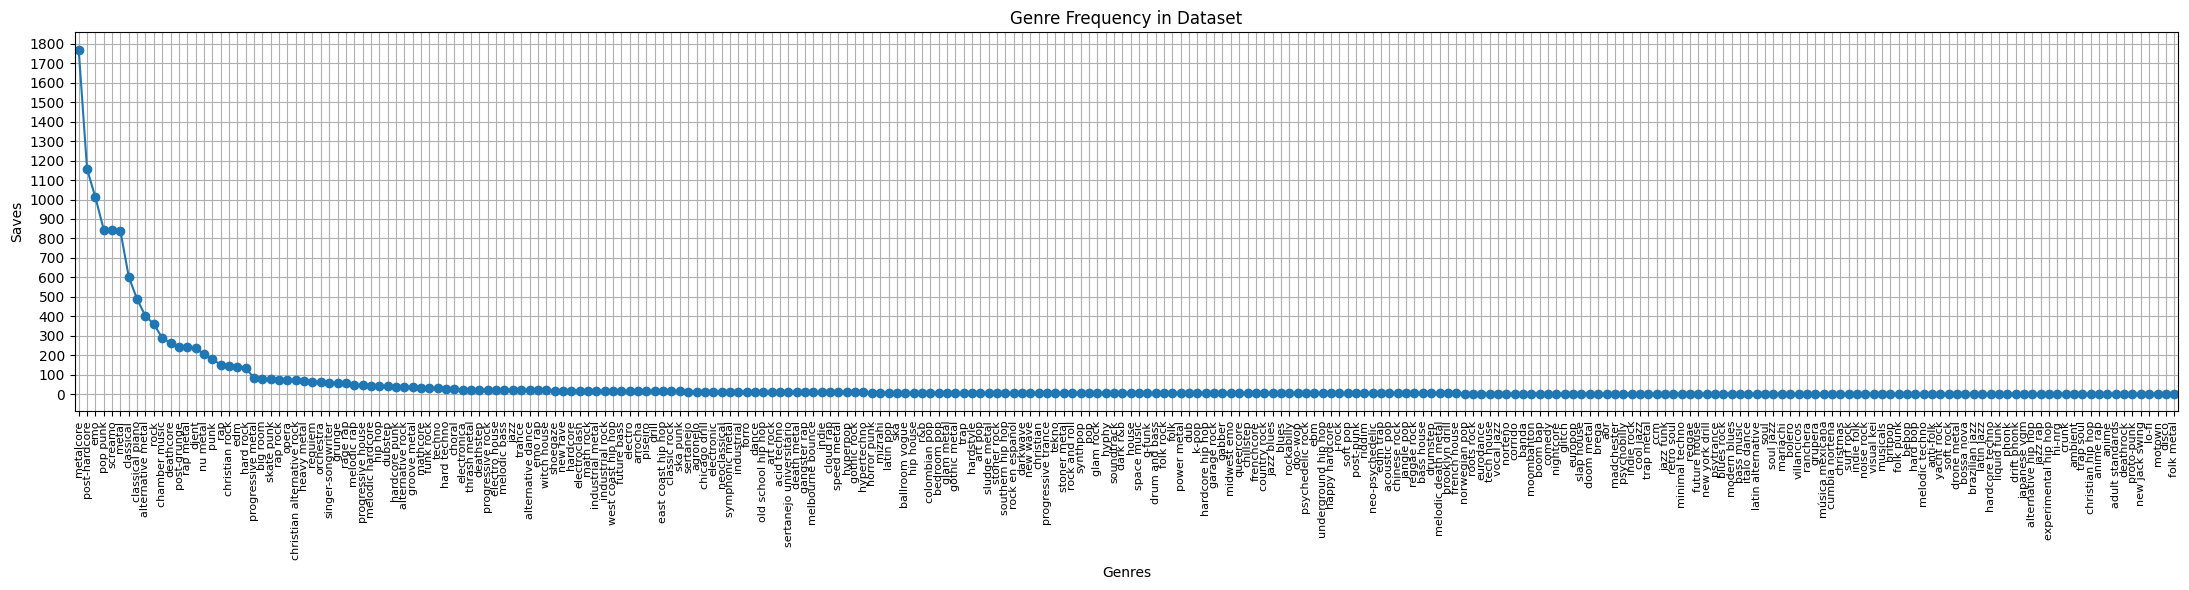

In [103]:
import matplotlib.pyplot as plt

# Sort genres by frequency
sorted_genres = genre_counts.most_common()

# Separate keys and values
genres, counts = zip(*sorted_genres)

# Plotting
plt.figure(figsize=(22, 6))
plt.plot(range(len(genres)), counts, marker='o', linestyle='-')
plt.xticks(ticks=range(len(genres)), labels=genres, rotation=90, fontsize=8)
plt.xlim(-0.5, len(genres) - 0.5)

import numpy as np

max_count = max(counts)
plt.yticks(np.arange(0, max_count + 100, 100))
plt.xlabel('Genres')
plt.ylabel('Saves')
plt.title('Genre Frequency in Dataset')
plt.tight_layout()
plt.grid(True)
plt.show()


In [104]:
# From visual analysis above
elbow = 80 

# Filter genres and counts
filtered_genres = [genre for genre, count in zip(genres, counts) if count < elbow]

print(f"{len(sorted_genres)} total genres")

print(f"{len(filtered_genres)} genres under {elbow} saves")


# Store the top dominating genres
dominating_genres = [genre for genre, count in zip(genres, counts) if count >= elbow]

percent_of_dominating = len(dominating_genres) / len(sorted_genres)

print(f"\n{len(dominating_genres)} genres dominate at only {percent_of_dominating:.1%} of total genres")
print(f"Dominating Genres: {dominating_genres}")

252 total genres
230 genres under 80 saves

22 genres dominate at only 8.7% of total genres
Dominating Genres: ['metalcore', 'post-hardcore', 'emo', 'pop punk', 'screamo', 'metal', 'classical', 'classical piano', 'alternative metal', 'rock', 'chamber music', 'deathcore', 'post-grunge', 'rap metal', 'djent', 'nu metal', 'punk', 'rap', 'christian rock', 'edm', 'hard rock', 'progressive metal']


In [15]:
# Test dump
dominating_genres = ['metalcore', 'post-hardcore', 'emo', 'pop punk', 'screamo', 'metal', 'classical', 'classical piano', 'alternative metal', 'rock', 'chamber music', 'deathcore', 'post-grunge', 'rap metal', 'djent', 'nu metal', 'punk', 'rap', 'christian rock', 'edm', 'hard rock', 'progressive metal']
with open("nick_artist_genres.txt", "w") as f:
    for genre in dominating_genres:
        f.write(f"{genre}\n")

### Take these top 22 genres to be One-Hot Encoded - Due to each artist having multiple genres (~Top 10%)

In [105]:
# Make sure NaNs are handled
df['artist_genre'] = df['artist_genre'].fillna('')

# Create new Columns
for genre in dominating_genres:
    col = "genre_" + genre.replace(' ', '_') # replace spaces with underscores
    df[col] = df['artist_genre'].str.contains(rf'\b{genre}\b').astype(int)

# Drop old column
df.drop(columns=['artist_genre'], inplace=True)

print(df.head().to_string(index=False)) # remove line wrapping in notebook


 track_duration  track_popularity  track_release_date  track_explicit  artist_popularity  artist_follower_count  artist_ranking  my_top_songs  artist_freq  genre_metalcore  genre_post-hardcore  genre_emo  genre_pop_punk  genre_screamo  genre_metal  genre_classical  genre_classical_piano  genre_alternative_metal  genre_rock  genre_chamber_music  genre_deathcore  genre_post-grunge  genre_rap_metal  genre_djent  genre_nu_metal  genre_punk  genre_rap  genre_christian_rock  genre_edm  genre_hard_rock  genre_progressive_metal
            198                67              201001               1                 58                 764241              21             1           58                1                    1          1               0              0            0                0                      0                        0           0                    0                0                  0                0            0               0           0          0                     0  

## Feature Selection (Checking Correlation) - artist_ranking and artist_freq

In [106]:
print(df['artist_ranking'].nunique())

# Somewhat related to frequency but not really
# If I really like an artist but only have 5 of their songs saved 

# Check correlation of both variables to target variable
# Close to 0 means little correlation
print(df[['my_top_songs', 'artist_freq', 'artist_ranking']].corr())

# artist_ranking and artist_freq have a moderate correlation - not enough to drop


496
                my_top_songs  artist_freq  artist_ranking
my_top_songs        1.000000     0.172262       -0.173483
artist_freq         0.172262     1.000000       -0.433497
artist_ranking     -0.173483    -0.433497        1.000000


In [107]:
# For the time being, I can leave the artist ranking, if I like an artist I will like their songs? The 496th artist doesnt get as much love as the 1st.

***

## Preview of Processed Data Set

In [108]:
# Move 'my_top_songs' to the end
col = df.pop('my_top_songs')
df['my_top_songs'] = col

print(df.head().to_string(index=False)) # remove line wrapping in notebook

 track_duration  track_popularity  track_release_date  track_explicit  artist_popularity  artist_follower_count  artist_ranking  artist_freq  genre_metalcore  genre_post-hardcore  genre_emo  genre_pop_punk  genre_screamo  genre_metal  genre_classical  genre_classical_piano  genre_alternative_metal  genre_rock  genre_chamber_music  genre_deathcore  genre_post-grunge  genre_rap_metal  genre_djent  genre_nu_metal  genre_punk  genre_rap  genre_christian_rock  genre_edm  genre_hard_rock  genre_progressive_metal  my_top_songs
            198                67              201001               1                 58                 764241              21           58                1                    1          1               0              0            0                0                      0                        0           0                    0                0                  0                0            0               0           0          0                     0          0     

In [110]:
df.to_csv("processed_data.csv", index=False)

In [37]:
# Note: I will have to shuffle (my_top_songs are ranked) and cross validate to handle class imbalance during training.

***

# XG Boost Prediction Model

In [38]:
pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 73.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.5/322.5 MB 75.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.1/35.1 MB 74.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [xgboost]m2/3 [xgboost]ccl-cu12]
Note: you may need to restart the kernel to use updated packages.


In [39]:
pip install scikit-learn

  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 32.9 MB/s eta 0:00:00a 0:00:01
Using cached threadpoolctl-3.6.0-py3-none-any.whl (18 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [scikit-learn] [scikit-learn]
Note: you may need to restart the kernel to use updated packages.


In [40]:
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

X = df.drop(columns=['my_top_songs']) # features
y = df['my_top_songs'] # prediction

# train/test splits - 80/20
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# define model
model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)

In [41]:
model.fit(X_train, y_train)

/home/nick/Documents/GitHub/spotifyapi/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [22:14:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [42]:
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.9207760711398545

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.97      0.96      1115
           1       0.64      0.45      0.53       122

    accuracy                           0.92      1237
   macro avg       0.79      0.71      0.74      1237
weighted avg       0.91      0.92      0.91      1237


Confusion Matrix:
 [[1084   31]
 [  67   55]]


In [43]:
pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Note: you may need to restart the kernel to use updated packages.


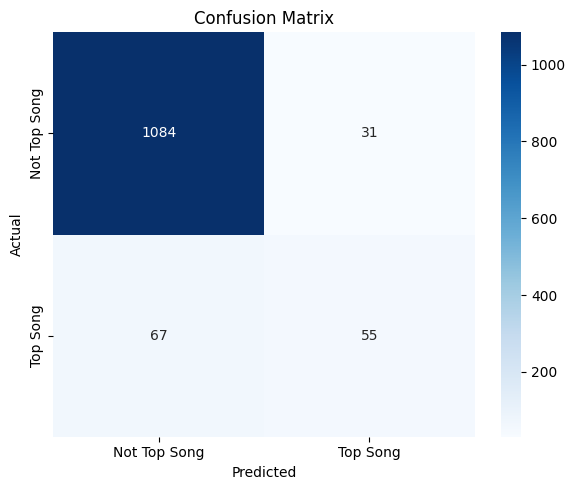

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Predict
y_pred = model.predict(X_test)

# Get confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Top Song', 'Top Song'], 
            yticklabels=['Not Top Song', 'Top Song'])

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()


# Light GBM Model Prediction

In [45]:
pip install lightgbm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 55.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [46]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Split data
X = df.drop(columns=['my_top_songs'])
y = df['my_top_songs']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

model = lgb.LGBMClassifier(
    objective='binary',
    random_state=42,
    n_estimators=100,
    learning_rate=0.05
)

In [47]:
model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 488, number of negative: 4458
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004577 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1260
[LightGBM] [Info] Number of data points in the train set: 4946, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.098666 -> initscore=-2.212140
[LightGBM] [Info] Start training from score -2.212140


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.05
,n_estimators,100
,subsample_for_bin,200000
,objective,'binary'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


              precision    recall  f1-score   support

           0       0.94      0.98      0.96      1115
           1       0.75      0.45      0.56       122

    accuracy                           0.93      1237
   macro avg       0.85      0.72      0.76      1237
weighted avg       0.92      0.93      0.92      1237



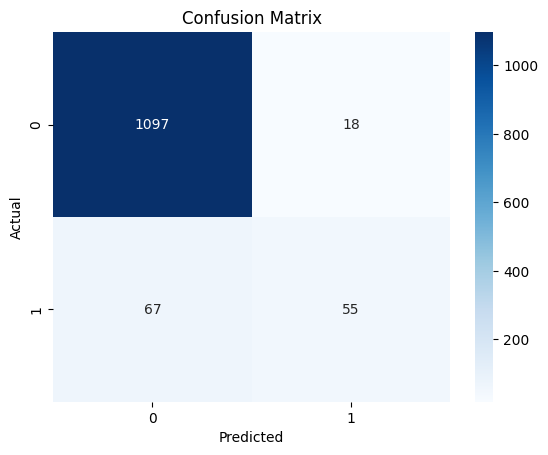

In [48]:
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

# Confusion matrix as a heatmap
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [49]:
# Save model to a file
import joblib

joblib.dump(model, 'lightgbm_model.pkl')

['lightgbm_model.pkl']

In [ ]:
# Load model from file
import joblib

model = joblib.load('lightgbm_model.pkl')


### Analyze False Positives - Type 1

In [118]:
import pandas as pd

# Load raw data
raw_df = pd.read_csv("raw_data.csv")

# Identify false positives
false_positives_mask = (y_pred == 1) & (y_test == 0)
false_positive_indices = y_test[false_positives_mask].index

# Get all columns from X_test for false positives
all_feature_data = X_test.loc[false_positive_indices]

# Get track and artist info
track_artist_info = raw_df.loc[false_positive_indices, ['track_name', 'artist_name']]

# Combine everything
false_positive_info = pd.concat([
    track_artist_info.reset_index(drop=True),
    all_feature_data.reset_index(drop=True)
], axis=1)

# Add actual/predicted columns
false_positive_info['actual'] = 0
false_positive_info['predicted'] = 1

# Save to CSV
print(false_positive_info.to_string())

false_positive_info.to_csv("false_positives.csv", index=False)
print("Saved false_positives.csv")


                                   track_name           artist_name  track_duration  track_popularity  track_release_date  track_explicit  artist_popularity  artist_follower_count  artist_ranking  artist_freq  genre_metalcore  genre_post-hardcore  genre_emo  genre_pop_punk  genre_screamo  genre_metal  genre_classical  genre_classical_piano  genre_alternative_metal  genre_rock  genre_chamber_music  genre_deathcore  genre_post-grunge  genre_rap_metal  genre_djent  genre_nu_metal  genre_punk  genre_rap  genre_christian_rock  genre_edm  genre_hard_rock  genre_progressive_metal  actual  predicted
0                                        Numb           Linkin Park             187                91              200303               0                 91               30373947              23           38                0                    0          0               0              0            1                0                      0                        1           1                    0  

### Analyze False Negatives - Type 2

In [117]:
import pandas as pd

# Load raw data
raw_df = pd.read_csv("raw_data.csv")

# Identify false negatives
false_negatives_mask = (y_pred == 0) & (y_test == 1)
false_negative_indices = y_test[false_negatives_mask].index

# Get all X_test columns for false negatives
all_feature_data = X_test.loc[false_negative_indices]

# Get track and artist info
track_artist_info = raw_df.loc[false_negative_indices, ['track_name', 'artist_name']]

# Combine everything
false_negative_info = pd.concat([
    track_artist_info.reset_index(drop=True),
    all_feature_data.reset_index(drop=True)
], axis=1)

# Add actual/predicted columns
false_negative_info['actual'] = 1
false_negative_info['predicted'] = 0

# Save to CSV
print(false_negative_info.to_string())

false_negative_info.to_csv("false_negatives.csv", index=False)
print("Saved false_negatives.csv")


                                                             track_name                 artist_name  track_duration  track_popularity  track_release_date  track_explicit  artist_popularity  artist_follower_count  artist_ranking  artist_freq  genre_metalcore  genre_post-hardcore  genre_emo  genre_pop_punk  genre_screamo  genre_metal  genre_classical  genre_classical_piano  genre_alternative_metal  genre_rock  genre_chamber_music  genre_deathcore  genre_post-grunge  genre_rap_metal  genre_djent  genre_nu_metal  genre_punk  genre_rap  genre_christian_rock  genre_edm  genre_hard_rock  genre_progressive_metal  actual  predicted
0                                                    Heartbreak Warfare                  John Mayer             269                67              200911               0                 79                6181996              16           55                0                    0          0               0              0            0                0                   

Note: There is something going on with the saved index of the Dataframe, there is some mismatch from all the df maniuplation, however the original raw_data.csv file contains the correct index that is stored per track

***

In [7]:
import pandas as pd

# Load the false negatives CSV
false_negative_info = pd.read_csv("false_negatives.csv")

# Count frequency of each artist in false negatives
artist_counts = false_negative_info[' artist_name               '].value_counts()

# Print top results
print(artist_counts.to_string)

<bound method Series.to_string of  artist_name               
The Used                      4
John Mayer                    3
Paramore                      3
My Chemical Romance           3
Motionless In White           3
A Day To Remember             2
Memphis May Fire              2
Bullet For My Valentine       2
The Red Jumpsuit Apparatus    2
Pierce The Veil               2
Tonight Alive                 2
Bad Omens                     2
Bring Me The Horizon          2
Ice Nine Kills                2
We Came As Romans             1
Avenged Sevenfold             1
Yours Truly                   1
Falling In Reverse            1
Diego & Victor Hugo           1
SICK PUPPIES                  1
thrown                        1
New Found Glory               1
Chevelle                      1
Escape the Fate               1
New Years Day                 1
Dragged Under                 1
If Not For Me                 1
Ludwig van Beethoven          1
In This Moment                1
Catch Your

In [ ]:
# TODO: Talbeau Report / Data Analyze the Errors from the Model

# TODO:? Testing Model on Fresh Data from Spotify API - Thinking Software Systems Wise

In [1]:
!pip install flask

  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached MarkupSafe-3.0.2-cp313-cp313-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.0 kB)
Using cached jinja2-3.1.6-py3-none-any.whl (134 kB)
Using cached MarkupSafe-3.0.2-cp313-cp313-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (23 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7 [flask]32m4/7 [werkzeug]
